In [9]:
import numpy as np
import cv2
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import os
%matplotlib inline

Method is executed only for first frame, because edges positions are fixed.

In [10]:
def get_left_and_right_edge(frame):
    edges = cv2.Canny(frame, 100, 200) #CannyEdge

    lines = cv2.HoughLinesP(image=edges, rho=1, theta=np.pi / 180, threshold=10, lines=np.array([]),
                            minLineLength=385, maxLineGap=20)  #Extract lines from edges

    #Initial value for edges
    left_edge = [960, 0, 960, 0]  
    right_edge = [0, 0, 0, 0]
    if lines is not None:
        for i in range(0, len(lines)):
            line = lines[i][0]
            (x1, y1), (x2, y2) = (line[0], line[1]), (line[2], line[3])
    
            if x1 == x2:  # condition for vertical line
                if x1 < left_edge[0]:
                    left_edge = [x1, y1, x2, y2]  # vertical line with minimum X value is left edge
                if x1 > right_edge[0]:
                    right_edge = [x1, y1, x2, y2] # vertical line with maximum X value is right edge
    
    #Mark edges on frame
    cv2.line(frame, (left_edge[0], left_edge[1]), (left_edge[2], left_edge[3]), (0, 0, 255), 3, cv2.LINE_AA)
    cv2.line(frame, (right_edge[0], right_edge[1]), (right_edge[2], right_edge[3]), (0, 0, 255), 3, cv2.LINE_AA)

    return left_edge, right_edge

For each frame we get balls positions.

In [11]:
def get_balls(frame):
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

    ret, image_bin = cv2.threshold(frame_gray, 150, 255, cv2.THRESH_BINARY)

    contours, hierarchy = cv2.findContours(image_bin, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    countours_balls = []
    for contour in contours:
        (x, y), r = cv2.minEnclosingCircle(contour) # (x, y) are center coordinates r is radius
        if 4 > r > 3.5:  # condition to see if contour is actually a ball
            countours_balls.append((x, y))
    return countours_balls

After extraction of balls positions, we need to check if ball hit the edge.

In [12]:
def check_for_contact(left_edge, right_edge, balls):
    left_edge_x = left_edge[0]
    right_edge_x = right_edge[0]
    for ball in balls:  # for each ball in frame we are checking if its X value is close enough to edge to consider it a hit
        x = ball[0]
        if x - left_edge_x <= 20:
            return True
        if right_edge_x - x <= 20:
            return True

Method that iterates through every frame of the video and returns actual count of hits.

In [13]:
def process_video(video_path):
    frame_num = 0
    cap = cv2.VideoCapture(video_path)
    cap.set(1, frame_num)  # indexing frames

    left_edge, right_edge = [], []
    hit_counter = 0
    # analyze video frame by frame
    previous_hit = -1 # variable that is used to avoid counting 1 hit as more(successive frames may be considered hits multiple times)
    
    while True:
        frame_num += 1
        ret_val, frame = cap.read()

        if not ret_val:
            break
            
        if frame_num == 1:  # for first frame get left and right edge
            left_edge, right_edge = get_left_and_right_edge(frame)

        balls = get_balls(frame)

        hit = check_for_contact(left_edge, right_edge, balls)
        
        if hit and frame_num > previous_hit + 2:
            hit_counter += 1
            previous_hit = frame_num

    return hit_counter

For each video we need to check how many hits actually happened. That information is in data/res.txt

In [14]:
def get_real_count_for_video(file_name, video_name):
    file_lbl = open(file_name, "r")
    for line in file_lbl.readlines():
        tokens = line.strip().split(",")
        if tokens[0] == video_name:
            return int(tokens[1])

MAE: 0.3


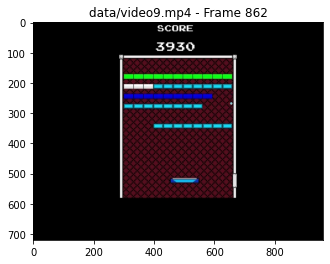

In [16]:
root_path = "data"

dataset = []

for file in os.listdir(root_path):
    filename = os.fsdecode(file)
    if filename.endswith(".mp4"):  # get every video from data folder and add it to dataset
        dataset.append(file)

# lists of real and predicted values to use for calculating mean absolute error
y_true = []
y_pred = []

for video in dataset:
    bounces = process_video(root_path + "/" + video) # get predicted value
    real = get_real_count_for_video(root_path + "/res.txt", video) # get real value
    y_true.append(real)
    y_pred.append(bounces)
    
mae = mean_absolute_error(y_true, y_pred)
print(f"MAE: {mae}")